In [99]:
# General assumption: weather data forecast is given (and accurate)
import pandas as pd
import numpy as np
import tensorflow as tf 

dataset = pd.read_csv('preprocessed/daily_data.csv')
dataset.head()

,day,temp_min,temp_max,feels_like,pressure,humidity,wind_speed,wind_deg,is_offday,demand,rrp
0,2015/01/01,18.818462,23.249231,19.723846,1014.769231,56.307692,2.880769,166.461538,1,4239.788511,24.967447
1,2015/01/02,23.112500,28.815833,23.994583,1012.041667,44.833333,3.297083,127.583333,0,5400.250417,30.940208
2,2015/01/03,27.044583,33.135000,25.151667,1009.500000,30.958333,7.962917,76.875000,1,5929.189167,33.128750
3,2015/01/04,17.069583,21.049583,16.899167,1016.208333,62.166667,4.544583,189.375000,1,4347.113125,24.755208
4,2015/01/05,15.143333,19.896667,15.582083,1020.166667,61.708333,3.671250,184.208333,0,4922.175000,25.689375


In [181]:
def create_dataset(df, window_size, forecast_size, batch_size, is_test=False):

    shuffle_buffer_size = len(df)
    # Total size of window is given by the number of steps to be considered
    # before prediction time + steps that we want to forecast
    total_size = window_size + forecast_size
    #print(df.values[:,1:])
    temp = np.asarray(df.values[:,1:]).astype(np.float32)
    data = tf.data.Dataset.from_tensor_slices(temp)

    # Selecting windows
    data = data.window(total_size, shift=forecast_size, drop_remainder=True)
    data = data.flat_map(lambda k: k.batch(total_size))

    # Shuffling data
    if not is_test:
        data = data.shuffle(shuffle_buffer_size, seed=42)
    
    # Separate past and feature
    data = data.map(lambda k: ((k[:window_size], k[window_size:, :8]), k[window_size:, 8])) 
    return data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [207]:
# Times at which to split train/validation and validation/test
train_split = 1325
val_test_split = 150

window_len = 7 # How much data from the past should we need for a forecast? (days)
forecast_len = 1  # How far ahead do we want to generate forecasts? (days)

# Splitting dataset into train/val/test
training_data = dataset.iloc[:train_split]
validation_data = dataset.iloc[train_split:train_split+val_test_split]
test_data = dataset.iloc[train_split+val_test_split:]

#normalize based on training
maxs = {}
for col in training_data.columns[1:]:
    training_data = training_data.copy()
    validation_data = validation_data.copy()
    test_data = test_data.copy()
    
    max_data = training_data[col].max()
    maxs[col] = max_data
    training_data[col] = training_data[col] / max_data
    validation_data[col] = validation_data[col] / max_data
    test_data[col] = test_data[col] / max_data

In [208]:
maxs

{'temp_min': 27.06083333333333,
 'temp_max': 33.142916666666665,
 'feels_like': 30.93166666666667,
 'pressure': 1036.9583333333333,
 'humidity': 99.54166666666669,
 'wind_speed': 7.9629166666666675,
 'wind_deg': 356.25,
 'is_offday': 1,
 'demand': 6877.941458333334,
 'rrp': 904.5291666666666}

In [209]:
# Now we get training, validation, and test as tf.data.Dataset objects
batch_size = 32
training_windowed = create_dataset(training_data, window_len, forecast_len, batch_size)
validation_windowed = create_dataset(validation_data, window_len, forecast_len, batch_size)
test_windowed = create_dataset(test_data, window_len, forecast_len, batch_size=1, is_test=True)

In [210]:
latent_dim = 100
n_total_features = 10
n_deterministic_features = 8

# First branch of the net is an lstm which finds an embedding for the past
past_inputs = tf.keras.Input(
    shape=(window_len, n_total_features), name='past_inputs')
# Encoding the past
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(past_inputs)

future_inputs = tf.keras.Input(
    shape=(forecast_len, n_deterministic_features), name='future_inputs')
# Combining future inputs with recurrent branch output
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True)
x = decoder_lstm(future_inputs,
                 initial_state=[state_h, state_c])

x = tf.keras.layers.Dense(64, activation='tanh')(x)
x = tf.keras.layers.Dense(32, activation='tanh')(x)
output = tf.keras.layers.Dense(1, activation='relu')(x)

model = tf.keras.models.Model(
    inputs=[past_inputs, future_inputs], outputs=output)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.Huber()
model.compile(loss=loss, optimizer=optimizer, metrics=["mae"])

In [211]:
history = model.fit(training_windowed, epochs=200,
                    validation_data=validation_windowed)

Epoch 1/200
42/42 [==============================] - 6s 137ms/step - loss: 0.0174 - mae: 0.1268 - val_loss: 0.0035 - val_mae: 0.0755
Epoch 2/200
42/42 [==============================] - 1s 26ms/step - loss: 0.0018 - mae: 0.0450 - val_loss: 0.0027 - val_mae: 0.0651
Epoch 3/200
42/42 [==============================] - 1s 25ms/step - loss: 0.0015 - mae: 0.0416 - val_loss: 0.0019 - val_mae: 0.0520
Epoch 4/200
42/42 [==============================] - 1s 23ms/step - loss: 0.0013 - mae: 0.0377 - val_loss: 0.0012 - val_mae: 0.0385
Epoch 5/200
42/42 [==============================] - 1s 22ms/step - loss: 0.0012 - mae: 0.0374 - val_loss: 0.0015 - val_mae: 0.0437
Epoch 6/200
42/42 [==============================] - 1s 26ms/step - loss: 0.0011 - mae: 0.0355 - val_loss: 0.0012 - val_mae: 0.0402
Epoch 7/200
42/42 [==============================] - 1s 28ms/step - loss: 0.0011 - mae: 0.0360 - val_loss: 0.0010 - val_mae: 0.0341
Epoch 8/200
42/42 [==============================] - 1s 25ms/step - loss: 0

Epoch 60/200
42/42 [==============================] - 1s 21ms/step - loss: 4.2598e-04 - mae: 0.0225 - val_loss: 0.0010 - val_mae: 0.0396
Epoch 61/200
42/42 [==============================] - 1s 23ms/step - loss: 4.5418e-04 - mae: 0.0238 - val_loss: 0.0011 - val_mae: 0.0411
Epoch 62/200
42/42 [==============================] - 1s 24ms/step - loss: 3.4715e-04 - mae: 0.0196 - val_loss: 2.9884e-04 - val_mae: 0.0181
Epoch 63/200
42/42 [==============================] - 1s 25ms/step - loss: 3.6714e-04 - mae: 0.0207 - val_loss: 6.5410e-04 - val_mae: 0.0300
Epoch 64/200
42/42 [==============================] - 1s 22ms/step - loss: 3.4521e-04 - mae: 0.0200 - val_loss: 9.5670e-04 - val_mae: 0.0386
Epoch 65/200
42/42 [==============================] - 1s 23ms/step - loss: 3.7105e-04 - mae: 0.0204 - val_loss: 5.6340e-04 - val_mae: 0.0263
Epoch 66/200
42/42 [==============================] - 1s 21ms/step - loss: 2.8999e-04 - mae: 0.0177 - val_loss: 3.7781e-04 - val_mae: 0.0222
Epoch 67/200
42/42 [=

42/42 [==============================] - 1s 23ms/step - loss: 3.1467e-04 - mae: 0.0187 - val_loss: 3.9913e-04 - val_mae: 0.0196
Epoch 119/200
42/42 [==============================] - 1s 18ms/step - loss: 2.6483e-04 - mae: 0.0171 - val_loss: 4.5344e-04 - val_mae: 0.0221
Epoch 120/200
42/42 [==============================] - 1s 17ms/step - loss: 3.1923e-04 - mae: 0.0188 - val_loss: 5.1596e-04 - val_mae: 0.0254
Epoch 121/200
42/42 [==============================] - 1s 22ms/step - loss: 2.8993e-04 - mae: 0.0181 - val_loss: 3.7193e-04 - val_mae: 0.0220
Epoch 122/200
42/42 [==============================] - 1s 19ms/step - loss: 3.0812e-04 - mae: 0.0186 - val_loss: 2.7737e-04 - val_mae: 0.0176
Epoch 123/200
42/42 [==============================] - 1s 17ms/step - loss: 3.3505e-04 - mae: 0.0196 - val_loss: 2.8515e-04 - val_mae: 0.0178
Epoch 124/200
42/42 [==============================] - 1s 20ms/step - loss: 2.6802e-04 - mae: 0.0172 - val_loss: 4.0191e-04 - val_mae: 0.0222
Epoch 125/200
42/42 

Epoch 176/200
42/42 [==============================] - 1s 23ms/step - loss: 2.5120e-04 - mae: 0.0165 - val_loss: 4.2152e-04 - val_mae: 0.0233
Epoch 177/200
42/42 [==============================] - 1s 24ms/step - loss: 3.1197e-04 - mae: 0.0187 - val_loss: 3.8051e-04 - val_mae: 0.0213
Epoch 178/200
42/42 [==============================] - 1s 23ms/step - loss: 2.9029e-04 - mae: 0.0181 - val_loss: 2.7601e-04 - val_mae: 0.0179
Epoch 179/200
42/42 [==============================] - 1s 18ms/step - loss: 2.4890e-04 - mae: 0.0158 - val_loss: 3.0098e-04 - val_mae: 0.0188
Epoch 180/200
42/42 [==============================] - 1s 22ms/step - loss: 2.3797e-04 - mae: 0.0161 - val_loss: 3.5666e-04 - val_mae: 0.0201
Epoch 181/200
42/42 [==============================] - 1s 24ms/step - loss: 2.7142e-04 - mae: 0.0172 - val_loss: 4.0604e-04 - val_mae: 0.0213
Epoch 182/200
42/42 [==============================] - 1s 23ms/step - loss: 2.6491e-04 - mae: 0.0175 - val_loss: 3.8534e-04 - val_mae: 0.0221
Epoch 

In [212]:
model.evaluate(test_windowed)

    619/Unknown - 4s 7ms/step - loss: 6.8563e-04 - mae: 0.0243

[0.0006856273170175296, 0.02432811]

In [213]:
preds=model.predict(test_windowed)*maxs['demand']

In [214]:
preds = np.reshape(preds, -1)

In [215]:
golds = test_data['demand']*maxs['demand']
golds = golds.tolist()[window_len:][:len(preds)]
days = test_data['day'].tolist()[window_len:][:len(preds)]

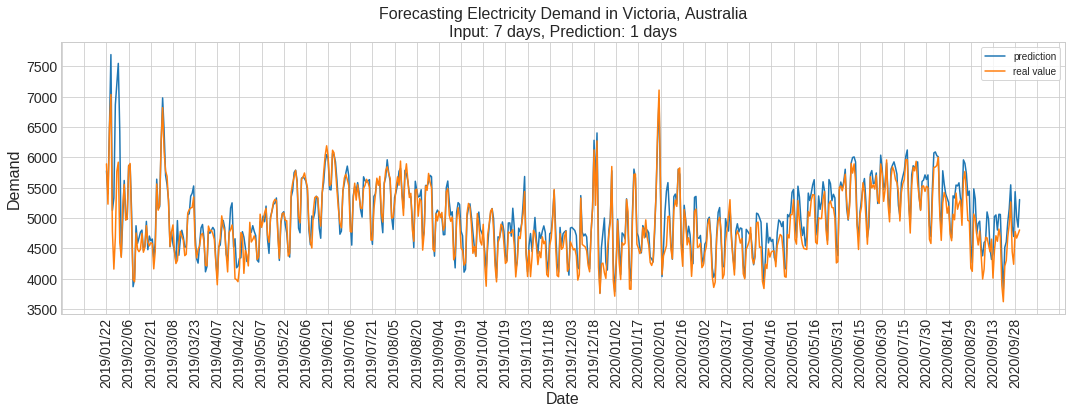

In [223]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

title = f'Forecasting Electricity Demand in Victoria, Australia\nInput: {window_len} days, Prediction: {forecast_len} days'
fig = plt.figure(figsize=(18,5))
ax = plt.axes()

plt.plot(days, preds, color='tab:blue', label='prediction')        # specify color by name
plt.plot(days, golds, color='tab:orange', label='real value')        # Grayscale between 0 and 1
plt.title(title, fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Demand', fontsize=16)
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(50))
#ax.set_ylim(ymin=0)
#ax.set_ylim(ymax=0.4)
plt.legend(frameon=True)
plt.tick_params(labelsize=14)
#fig.savefig("daily_forecast_demand(7to7)V2.pdf", bbox_inches='tight')

In [217]:

#14 days -- 7 days, MAE 0.0298
#7 days -- 7 days, MAE 0.0271
#14 days -- 1 days, MAE 0.0247
#7 days -- 1 days, MAE 0.0187


In [218]:
res = abs(preds-golds)
day2res_2019 = {}
day2res_2020 = {}
for idx, d in enumerate(days):
    if (d >= '2019/04/01' and d <= '2019/10/01'):
        time='/'.join(d.split('/')[1:])
        day2res_2019[time] = res[idx]
    if (d >= '2020/04/01' and d <= '2020/10/01'):
        time='/'.join(d.split('/')[1:])
        day2res_2020[time] = res[idx]
        
        
new_day2019=[];new_day2020=[]
new_res2019=[];new_res2020=[]
for key in day2res_2020.keys():
    new_day2019.append(key)
    new_res2019.append(day2res_2019[key])
    new_day2020.append(key)
    new_res2020.append(day2res_2020[key])
    
assert new_day2019 == new_day2020

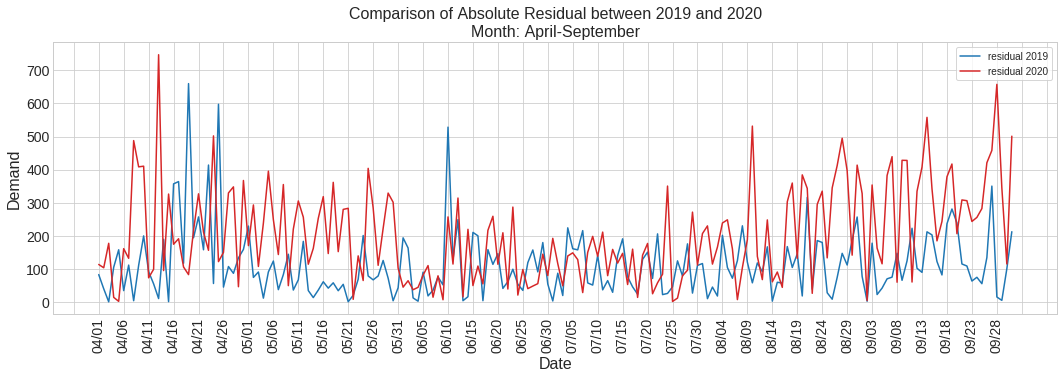

In [224]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

title = 'Comparison of Absolute Residual between 2019 and 2020\nMonth: April-September'
fig = plt.figure(figsize=(18,5))
ax = plt.axes()

plt.plot(new_day2019, new_res2019, color='tab:blue', label='residual 2019')      # Grayscale between 0 and 1
plt.plot(new_day2019, new_res2020, color='tab:red', label='residual 2020')      # Grayscale between 0 and 1
plt.title(title, fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Demand', fontsize=16)
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(50))
#ax.set_ylim(ymin=0)
#ax.set_ylim(ymax=0.4)
plt.legend(frameon=True)
plt.tick_params(labelsize=14)
#fig.savefig("residual_daily_forecast_demand(7to7)V2.pdf", bbox_inches='tight')